In [1]:
#-*- coding:utf-8 -*-
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import datetime
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,recall_score,precision_score
from scipy.stats import describe
from visdom import Visdom

Variational Auto Encoder 활용

In [5]:
os.chdir('..')
os.chdir('./기상청공모전/실험/6_20/8')

In [8]:
class Config(dict):
    __getattr__=dict.__getitem__
    __setattr__=dict.__setitem__

In [9]:
config=Config({'batch_size':128,'hidden_dim':16,'latent_dim':8,'input_dim':26,'device':torch.device('cuda' if torch.cuda.is_available() else 'cpu'),'momentum':0.1})

In [14]:
plant1_data=pd.read_csv('G:/기상청공모전/데이터/최신/plant1_data_dropna_dang.csv',index_col=0,header=0,encoding='utf-8')
plant2_data=pd.read_csv('G:/기상청공모전/데이터/최신/plant2_data_dropna_dang.csv',index_col=0,header=0,encoding='utf-8')

In [18]:
plant1_data.columns

Index(['plant1_train.mea_ddhr', 'plant1_train.tem_in_loc1',
       'plant1_train.hum_in_loc1', 'plant1_train.tem_coil_loc1',
       'plant1_train.tem_in_loc2', 'plant1_train.hum_in_loc2',
       'plant1_train.tem_coil_loc2', 'plant1_train.tem_in_loc3',
       'plant1_train.hum_in_loc3', 'plant1_train.tem_coil_loc3',
       'plant1_train.tem_out_loc1', 'plant1_train.hum_out_loc1',
       'plant1_train.cond_loc1', 'plant1_train.cond_loc2',
       'plant1_train.cond_loc3', 'datetime_x', '일시_x', '기온(°C)_x', '강수량(mm)_x',
       '풍속(m/s)_x', '풍향(16방위)', '습도(%)_x', '증기압(hPa)', '이슬점온도(°C)',
       '현지기압(hPa)', '해면기압(hPa)', '적설(cm)', '지면온도(°C)', '기온(°C)_y', '풍속(m/s)_y',
       '강수량(mm)_y', '습도(%)_y'],
      dtype='object')

In [19]:
columns1=list(plant1_data.columns)
columns1.remove('plant1_train.mea_ddhr')
columns1.remove('datetime_x')
columns1.remove('일시_x')

In [21]:
columns2=list(plant2_data.columns)
columns2.remove('plant2_train.mea_ddhr')
columns2.remove('datetime_x')
columns2.remove('일시_x')

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler_1=MinMaxScaler()
data1=scaler_1.fit_transform(plant1_data.loc[:,columns1])
plant1=df(data1,columns=columns1)

scaler_2=MinMaxScaler()
data2=scaler_2.fit_transform(plant2_data.loc[:,columns2])
plant2=df(data2,columns=columns2)


In [24]:
class encoding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.fc=nn.Sequential(nn.Linear(self.config.input_dim,self.config.hidden_dim),nn.ReLU())
        self.Mu=nn.Linear(self.config.hidden_dim,self.config.latent_dim)
        self.Log_var=nn.Linear(self.config.hidden_dim,self.config.latent_dim) # log var로 하는 것이, 범위 조건이 없으므로
        
    def forward(self,data):
        x=data
        x=self.fc(x)
        mu=self.Mu(x)
        log_var=self.Log_var(x)
        return mu,log_var
    
class decoding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.post_mu=nn.Linear(self.config.latent_dim,self.config.hidden_dim)
        self.post_logvar=nn.Linear(self.config.latent_dim,self.config.hidden_dim)
        self.fc=nn.Sequential(nn.Linear(self.config.hidden_dim,self.config.input_dim),nn.Sigmoid())
    def forward(self,z):
        post_mu=self.post_mu(z)
        post_logvar=self.post_logvar(z)
        e=torch.randn_like(post_logvar).to(self.config.device)
        x=(e*torch.exp(0.5*post_logvar).to(self.config.device))+post_mu
        output=self.fc(x)
        return output

class variational_auto_encoder(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config=config
        self.encoder=encoding(config)
        self.decoder=decoding(config)
        
    def reparametrization(self,mu,log_var):
        sigma=torch.exp(0.5*log_var).to(self.config.device)
        e=torch.randn_like(sigma).to(self.config.device)
        z=mu+sigma*e
        return z
        
    def forward(self,data):
        mu,log_var=self.encoder(data)
        z=self.reparametrization(mu,log_var)
        output=self.decoder(z)
        return output,mu,log_var

In [25]:
def train():
    avg_loss=0
    avg_loss1=0
    avg_loss2=0
    n=0
    
    for x in train_data_loader:
        x=x.to(config.device)
        x_,mu,log_var=model(x)
        optimizer.zero_grad() 
        
        BCE=F.binary_cross_entropy(x_,x,size_average=False) # scaling을 해줘야한다..
        KL=-0.5*(log_var+1.-log_var.exp()-mu.pow(2)).sum()
        loss=BCE+KL
        avg_loss+=loss.item()
        avg_loss1+=BCE.item()
        avg_loss2+=KL.item()
        n+=1
        loss.backward()
        optimizer.step()
    viz.line(X=[[epoch,epoch,epoch]],Y=[[avg_loss/n,avg_loss1/n,avg_loss2/n]],win=win2,update='append',env='%s'%(target))    
    

In [26]:
def save_train_test_normal_anormal():
    y=plant.loc[:,target]
    normal_x=plant.loc[y==0,feature].to_numpy()
    anormal_x=plant.loc[y==1,feature].to_numpy()
    train_normal_x,test_normal_x=train_test_split(normal_x,test_size=0.005)
    train_anormal_x,test_anormal_x=train_test_split(anormal_x,test_size=0.5)
    train_normal_x=torch.FloatTensor(train_normal_x)
    test_normal_x=torch.FloatTensor(test_normal_x)
    train_anormal_x=torch.FloatTensor(train_anormal_x)
    test_anormal_x=torch.FloatTensor(test_anormal_x)
    torch.save(train_normal_x,'./train_normal_%s'%target)
    torch.save(test_normal_x,'./test_normal_%s'%target)
    torch.save(train_anormal_x,'./train_anormal_%s'%target)
    torch.save(test_anormal_x,'./test_anormal_%s'%target)
    return train_normal_x,train_anormal_x

In [27]:
feature=columns1.copy()
feature.remove('plant1_train.cond_loc1')
feature.remove('plant1_train.cond_loc2')
feature.remove('plant1_train.cond_loc3')
targets=['plant1_train.cond_loc1','plant1_train.cond_loc2','plant1_train.cond_loc3']

In [ ]:
plant=plant1
for target in targets:
    viz=Visdom()
    win2 = viz.line(X=[[0,0,0]],Y=[[0,0,0]],opts=dict(legend=['total_loss','BCE','KL']),env='%s'%(target))
    train_normal_x,train_anormal_x=save_train_test_normal_anormal()
    train_data_loader=torch.utils.data.DataLoader(train_normal_x,batch_size=config.batch_size,shuffle=True,drop_last=True)
    import time
    now=time.time()
    model=variational_auto_encoder(config).to(config.device) # input dim 16, hidden dim  64
    optimizer=torch.optim.Adam(model.parameters())
    model.train()
    for epoch in range(500):
        train()

    print(time.time()-now)
    torch.save(model.state_dict(),'./%s'%target)           

Setting up a new session...
C:\Users\IDSL\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


3412.404300928116


Setting up a new session...


3501.759396314621


Setting up a new session...


In [ ]:
feature=columns2.copy()
feature.remove('plant2_train.cond_loc1')
feature.remove('plant2_train.cond_loc2')
feature.remove('plant2_train.cond_loc3')
targets=['plant2_train.cond_loc1','plant2_train.cond_loc2','plant2_train.cond_loc3']
plant=plant2
for target in targets:
    viz=Visdom()
    win2 = viz.line(X=[[0,0,0]],Y=[[0,0,0]],opts=dict(legend=['total_loss','BCE','KL']),env='%s'%(target))
    train_normal_x,train_anormal_x=save_train_test_normal_anormal()
    train_data_loader=torch.utils.data.DataLoader(train_normal_x,batch_size=config.batch_size,shuffle=True,drop_last=True)
    import time
    now=time.time()
    model=variational_auto_encoder(config).to(config.device) # input dim 16, hidden dim  64
    optimizer=torch.optim.Adam(model.parameters())
    model.train()
    for epoch in range(500):
        train()

    print(time.time()-now)
    torch.save(model.state_dict(),'./%s'%target)           

C:\Users\IDSL\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


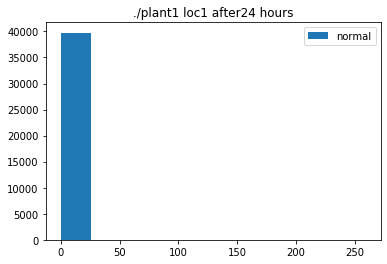

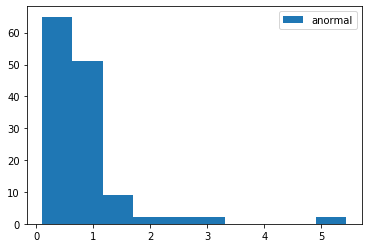

6sigma 범위만 생각
normal min 0.02
normal max 13.87
normal mean 0.39
normal median 0.24
normal std 0.64
anormal min 0.11
anormal max 5.44
anormal mean 0.80
anormal median 0.65
anormal std 0.73
train
true_positive  0
false_positive  28
false_negative  133
true_negative  39730


acc  0.9959640019051916
precision  0.0
recall  0.0
test
true_positive  0
false_positive  0
false_negative  134
true_negative  286


acc  0.9959640019051916
precision  nan
recall  0.0


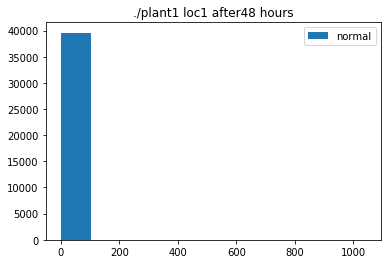

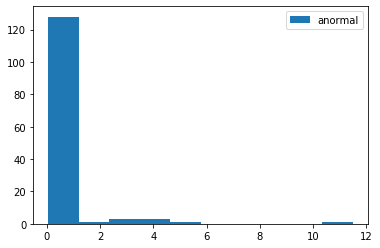

6sigma 범위만 생각
normal min 0.02
normal max 33.59
normal mean 0.41
normal median 0.25
normal std 0.86
anormal min 0.06
anormal max 11.49
anormal mean 0.57
anormal median 0.24
anormal std 1.24
train
true_positive  0
false_positive  7
false_negative  137
true_negative  39585


acc  0.9963754436305973
precision  0.0
recall  0.0
test
true_positive  0
false_positive  0
false_negative  137
true_negative  285


acc  0.9963754436305973
precision  nan
recall  0.0


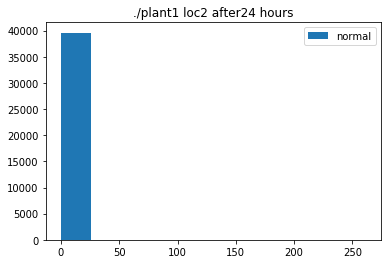

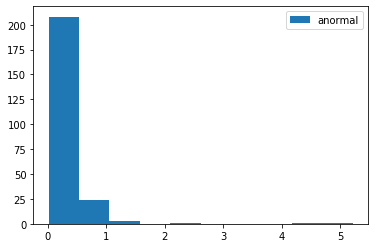

6sigma 범위만 생각
normal min 0.01
normal max 16.26
normal mean 0.27
normal median 0.14
normal std 0.63
anormal min 0.02
anormal max 5.22
anormal mean 0.30
anormal median 0.18
anormal std 0.50
train
true_positive  0
false_positive  21
false_negative  238
true_negative  39591


acc  0.9935006273525722
precision  0.0
recall  0.0
test
true_positive  0
false_positive  0
false_negative  239
true_negative  285


acc  0.9935006273525722
precision  nan
recall  0.0


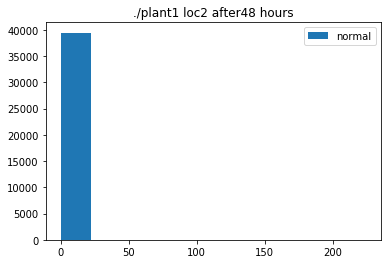

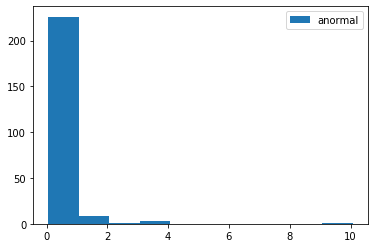

6sigma 범위만 생각
normal min 0.01
normal max 14.31
normal mean 0.40
normal median 0.26
normal std 0.64
anormal min 0.06
anormal max 10.07
anormal mean 0.44
anormal median 0.29
anormal std 0.77
train
true_positive  0
false_positive  24
false_negative  239
true_negative  39426


acc  0.9933734787976517
precision  0.0
recall  0.0
test
true_positive  0
false_positive  1
false_negative  239
true_negative  283


acc  0.9933734787976517
precision  0.0
recall  0.0


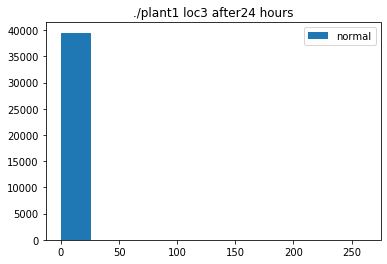

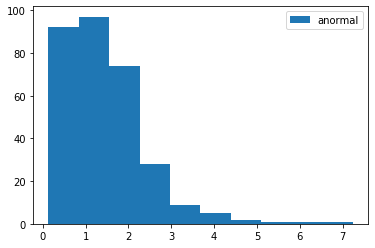

6sigma 범위만 생각
normal min 0.04
normal max 17.97
normal mean 1.35
normal median 0.96
normal std 1.41
anormal min 0.13
anormal max 7.23
anormal mean 1.47
anormal median 1.28
anormal std 0.96
train
true_positive  0
false_positive  7
false_negative  310
true_negative  39505


acc  0.992039576113706
precision  0.0
recall  0.0
test
true_positive  0
false_positive  0
false_negative  310
true_negative  284


acc  0.992039576113706
precision  nan
recall  0.0


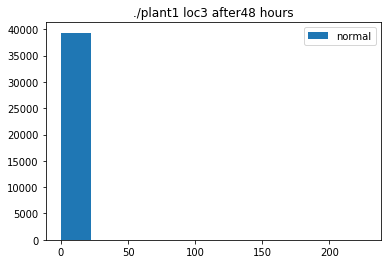

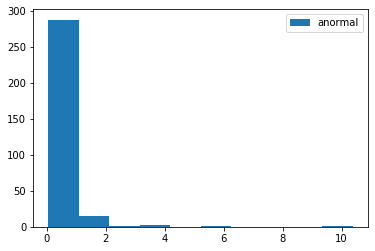

6sigma 범위만 생각
normal min 0.01
normal max 12.82
normal mean 0.40
normal median 0.26
normal std 0.60
anormal min 0.06
anormal max 10.38
anormal mean 0.49
anormal median 0.30
anormal std 0.78
train
true_positive  0
false_positive  36
false_negative  309
true_negative  39317


acc  0.9913014976551863
precision  0.0
recall  0.0
test
true_positive  0
false_positive  0
false_negative  309
true_negative  283


acc  0.9913014976551863
precision  nan
recall  0.0


[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다
[WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하

In [25]:
# plant 1,2

device=config.device
N=0
values={}
for i in ['1']:
    # loc 1,2,3
    for j in ['1','2','3']:
        # 24,48
        train_normal_x=torch.load('./train_normal_plant%s_train.cond_loc%s'%(i,j))
        train_anormal_x=torch.load('./train_anormal_plant%s_train.cond_loc%s'%(i,j))
        ae=AutoEncoder(config).to(device)
        ae.load_state_dict(torch.load('./plant%s_train.cond_loc%s'%(i,j)))
        test_normal=torch.load('./test_normal_plant%s_train.cond_loc%s'%(i,j))
        test_anormal=torch.load('./test_anormal_plant%s_train.cond_loc%s'%(i,j))
        with torch.no_grad():
            ae.eval()
            normal=F.mse_loss(ae(train_normal_x.to(config.device)),train_normal_x.to(config.device),reduce=False).mean(dim=1).to('cpu')
            anormal=F.mse_loss(ae(train_anormal_x.to(config.device)),train_anormal_x.to(config.device),reduce=False).mean(dim=1).to('cpu')
            plt.title('./plant%s loc%s after'%(i,j))
            plt.hist(normal,label='normal')
            plt.legend(loc='best')
            plt.show()
            plt.hist(anormal,label='anormal')
            plt.legend(loc='best')
            plt.show()
            n=normal[((normal-normal.mean())/normal.std())<6]
            print('6sigma 범위만 생각')
            print('normal min %.2f'%(n.min()))
            print('normal max %.2f'%(n.max()))
            print('normal mean %.2f'%(n.mean()))
            print('normal median %.2f'%(np.median(n)))
            print('normal std %.2f'%(n.std()))
            values['%s_%s_%s'%(i,j,k)]=n.max()+6*n.std() if n.max()>anormal.min() else n.max()
            print('anormal min %.2f'%(anormal.min()))
            print('anormal max %.2f'%(anormal.max()))
            print('anormal mean %.2f'%(anormal.mean()))
            print('anormal median %.2f'%(np.median(anormal)))
            print('anormal std %.2f'%(anormal.std()))
            train_normal=torch.load('./train_normal_plant%s_train.cond_loc%s'%(i,j)).to(device)
            train_anormal=torch.load('./train_anormal_plant%s_train.cond_loc%s'%(i,j)).to(device)

            print('train')
            normal_score=(F.mse_loss(ae(train_normal),train_normal,reduce=False).mean(dim=1)>values['%s_%s'%(i,j)]).long()
            anormal_score=(F.mse_loss(ae(train_anormal),train_anormal,reduce=False).mean(dim=1)>values['%s_%s'%(i,j)]).long()

            true_positive=(anormal_score==1).sum().item()
            true_negative=(normal_score==0).sum().item()
            false_positive=(normal_score==1).sum().item()
            false_negative=(anormal_score==0).sum().item()
            print('true_positive ', true_positive)
            print('false_positive ', false_positive)
            print('false_negative ', false_negative)
            print('true_negative ', true_negative)
            print('\n')
            acc=((normal_score==0).sum()+(anormal_score==1).sum()).item()/(len(normal_score)+len(anormal_score))
            try:
                precision=(anormal_score==1).sum().item()/((normal_score==1).sum().item()+(anormal_score==1).sum().item())
            except:
                precision=np.nan

            try: 
                recall=(anormal_score==1).sum().item()/len(anormal_score)
            except:
                recall=np.nan
            print('acc ',acc)
            print('precision ',precision)
            print('recall ',recall)

            print('test')
            test_normal=test_normal.to(device)
            test_anormal=test_anormal.to(device)
            normal_score=(F.mse_loss(ae(test_normal),test_normal,reduce=False).mean(dim=1)>values['%s_%s'%(i,j)]).long()
            anormal_score=(F.mse_loss(ae(test_anormal),test_anormal,reduce=False).mean(dim=1)>values['%s_%s'%(i,j)]).long()

            true_positive=(anormal_score==1).sum().item()
            true_negative=(normal_score==0).sum().item()
            false_positive=(normal_score==1).sum().item()
            false_negative=(anormal_score==0).sum().item()
            print('true_positive ', true_positive)
            print('false_positive ', false_positive)
            print('false_negative ', false_negative)
            print('true_negative ', true_negative)
            print('\n')
            try:
                precision=(anormal_score==1).sum().item()/((normal_score==1).sum().item()+(anormal_score==1).sum().item())
            except:
                precision=np.nan

            try: 
                recall=(anormal_score==1).sum().item()/len(anormal_score)
            except:
                recall=np.nan
            print('acc ',acc)
            print('precision ',precision)
            print('recall ',recall)